Learn advanced techniques to improve Computer Vision models. Explore how to work w/ real-world images in different shapes & sizes, visualize the journey of an image through convolutions to understand how the computer "sees" info., plot loss & accuracy, and explore strategies to prevent overfitting, incl. augmentation & dropout. Also, learn Transfer Learning and how Features can be Extracted from models.

# § 02.01. Exploring a Larger Dataset

## Using more sophisticated images w/ CNNs

You saw previously how to use a CNN to make your recognition of the handwriting digits more efficient. In this lesson you'll take that to the next level, recognizing real images of Cats & Dogs in order to classify an incoming image as one or the other.

In particular, the handwriting recognition made your life a little easier by having all the images be the same size & shape, and they were all monochrome color. Real-world images aren't like that--they're in different shapes, aspect ratios etc., and they're usually in color!

So, as part of the task you need to process your data--not least, resizing it to be uniform in shape. You'll follow these steps:

1.   Explore the Data (Ex. of Cats & Dogs);
2.   Build & Train the Model (a NN to recognize the <> bw. the 2);
3.   Evaluate the Model (training, validation and testing Accuracy).

**1. Explore the Data**

Let's start by downloading our sample data, a .zip of 2,000 JPG pictures of cats & dogs (a subset of the https://www.kaggle.com/c/dogs-vs-cats/data dataset, which contains 25,000 images).

In [65]:
!wget --no-check-certificate \
    "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip" \
    -O "/tmp/cats_and_dogs_filtered.zip"

--2024-01-25 13:56:39--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.159.207, 142.251.120.207, 142.251.161.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.159.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  98.3MB/s    in 0.7s    

2024-01-25 13:56:39 (98.3 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



The following Python code will use the OS library giving you access to the file system, and the zipfile library allowing you to unzip the data.

In [66]:
import os
import zipfile

In [67]:
local_zip = '/tmp/cats_and_dogs_filtered.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/tmp')
zip_ref.close()

The contents of the .zip are extracted to the base directory `/tmp/cats_and_dogs_filtered`, which contains `train` and `validation` subdirectories for the Training and Validation datasets (see the https://developers.google.com/machine-learning/crash-course/validation/check-your-intuition for a refresher on Training, Validation, and Test sets), which in turn each contain `cats` and `dogs` subdirectories.

In short, the Training set is the data that is used to tell the NN model that "this is what a cat looks like", "this is what a dog looks like" etc. The Validation dataset contains images of cats & dogs that the NN will not "see" as part of the training, so you can test how well / badly it does in evaluating if an image contains a cat / dog.

Note: We do not explicitly label the images as cats or dogs. [If you remember w/ the handwriting ex. earlier, we had labelled "this is a 1", "this is a 7" etc.] Later, you'll see something called an `ImageGenerator` being used--coded to read images from subdirectories, and automatically label them from the name of that subdirectory.

In [68]:
base_dir = '/tmp/cats_and_dogs_filtered'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory w/ our training cat-dog pictures
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory w/ our validation cat-dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [69]:
train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

print(train_cat_fnames[:10])
print(train_dog_fnames[:10])

['cat.145.jpg', 'cat.360.jpg', 'cat.531.jpg', 'cat.484.jpg', 'cat.175.jpg', 'cat.843.jpg', 'cat.606.jpg', 'cat.363.jpg', 'cat.661.jpg', 'cat.772.jpg']
['dog.109.jpg', 'dog.404.jpg', 'dog.2.jpg', 'dog.93.jpg', 'dog.438.jpg', 'dog.989.jpg', 'dog.501.jpg', 'dog.256.jpg', 'dog.591.jpg', 'dog.264.jpg']


In [70]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))

print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500


Let's take a look at a few pictures to get a better sense of what the cat & dog datasets look like. First, configure the matplot parameters:

In [71]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

pic_index = 0 # Index for iterating over images

Now, display a batch of 8 cat & 8 dog pictures. Rerun the cell to see a fresh batch each time:

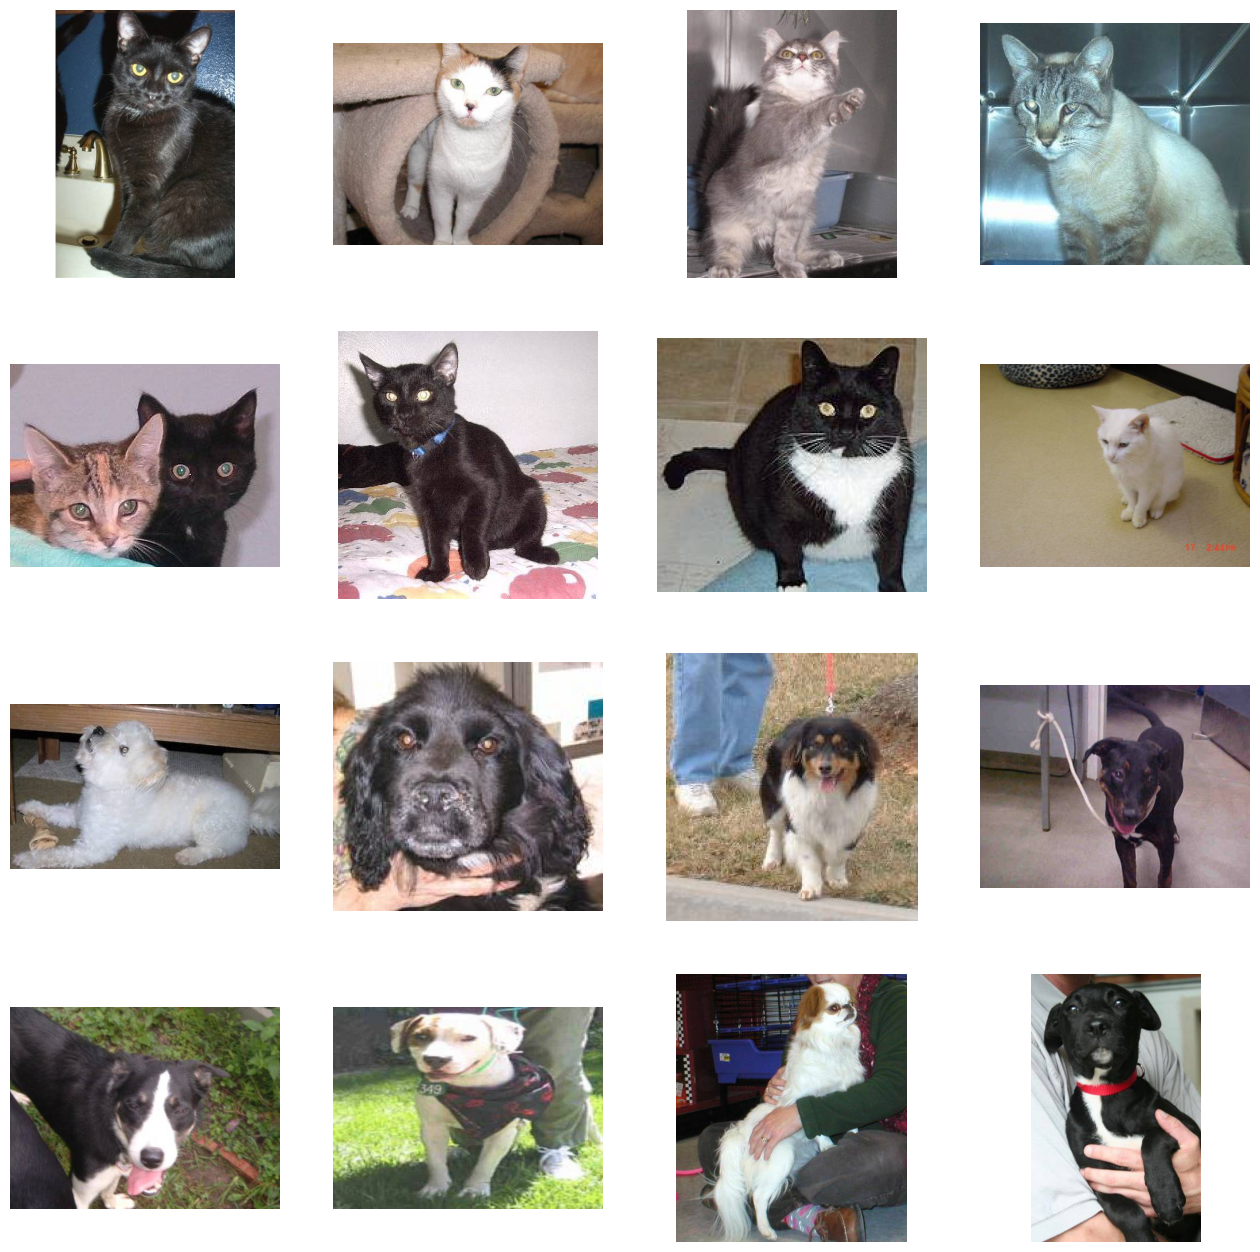

In [72]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index += 8

next_cat_pix = [
    os.path.join(train_cats_dir, fname)
    for fname in train_cat_fnames[pic_index-8 : pic_index]
]

next_dog_pix = [
    os.path.join(train_dogs_dir, fname)
    for fname in train_dog_fnames[pic_index-8 : pic_index]
]

for i, img_path in enumerate(next_cat_pix + next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

It may not be obvious from looking at the images in this grid, but an important note here, and a significant difference from the previous lesson is that these images come in all shapes and sizes. Before training a NN w/ them, we'll need to tweak the images to get them to be in a uniform size--we've chosen 150x150 for this.

**2. Build & Train the Model**

Data Preprocessing

Let's set up data generators (1 for the training images, and 1 for the validation images) that will read pictures in our source folders, convert them to `float32` tensors, and feed them (w/ their labels) to our network. Our generators will yield batches of 20 images of size 150x150 and their labels(`binary`).

Also, the data that goes into NN should be normalized in some way to make it more amendable to processing by the network [it is uncommon to feed raw pixels into a CNN]. In our case, we will preprocess our images by normalizing the pixel values to be in the [0, 1] range (originally, all values are in the [0, 255] range).

In Keras, this can be done via the `keras.preprocessing.image.ImageDataGenerator` class, using the `rescale` parameter, this class allowing you to instantiate generators of augmented image batches (and their labels) via `.flow(data, labels)` or `.flow_from_directory(directory)`. These generators can then be used w/ the Keras model methods that accept data generators as inputs: `fit`, `evaluate_generator`, and `predict_generator`.

In [73]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [74]:
# All images will be rescaled by 1/255.
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150, 150))

# Flow validation images in batches of 20 using test_datagen generator
# [?!! should hold out validation from training set to eval. several candidate Models <> test set for Data!! Anyway ...]
validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                        batch_size=20,
                                                        class_mode='binary',
                                                        target_size=(150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Let's start def. a (sequential) model from scratch to get to ~ 72% accuracy:
- Input Layer--note the input shape parameter this time. In the earlier ex. it was 28x28x1, because the image was of size 28x28 and in greyscale or x1 (8 bits = 1 byte) for color depth. This time it is 150x150 for the size and in RGB (red, green, blue) or x3 (24 bits = 3 bytes) for the color depth.
- We then add a couple of Convolutional Layers as in the previous ex., and Flatten the final result to feed into the hidden densely connected layers.
- Finally, we add the Dense Layers.
- Output Layer--note that, because we are facing a 2-class / *binary claffication problem*, we will end our network w/ a *sigmoid* activation (https://en.wikipedia.org/wiki/Sigmoid_function), so that the output of our network will be a single scalar bw. 0-1, encoding the probability that the current image is class 1 / dogs (as opposed to class 0 / cats).

In [75]:
import tensorflow as tf

In [76]:
model = tf.keras.models.Sequential([
    # Input layer w/ input shape of desired size of the images: 150x150 w/ 3 bytes color
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # Hidden layer w/ 512 neurons
    tf.keras.layers.Dense(512, activation='relu'),
    # Output layer w/ 1 neuron: binary, '0' for the class 'cats' & '1' for 'dogs'
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [77]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_39 (Conv2D)          (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_39 (MaxPooli  (None, 74, 74, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_40 (Conv2D)          (None, 72, 72, 16)        2320      
                                                                 
 max_pooling2d_40 (MaxPooli  (None, 36, 36, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_41 (Conv2D)          (None, 34, 34, 16)        2320      
                                                                 
 max_pooling2d_41 (MaxPooli  (None, 17, 17, 16)       

The "output shape" column shows how the size of your feature map evolves in each successive layer. The Convolution Layers reduce the size of the feature maps by a bit due to padding, and each Pooling layer halves the dimensions.

Next, we'll configure the specifications for model training:
- we will train our model w/ the `binary_crossentropy` loss, because it's a binary classification problem and our final activation is a `sigmoid`;
- we will use the `rmsprop` optimizer w/ a learning rate of `0.001` [**NOTE**: In this case, using the [RMSprop](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#RMSProp) is preferable to [SGD](https://developers.google.com/machine-learning/glossary/#SGD), because RMSprop automates learning-rate tuning for us. Other optimizers, such as [Adam](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Adam) and [Adagrad](https://developers.google.com/machine-learning/glossary/#AdaGrad), also automatically adapt the learning rate during training, and would work equally well here];
- during training, we will want to monitor classification `accuracy`.

In [78]:
from tensorflow.keras.optimizers import RMSprop

In [79]:
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['accuracy'])

Let's train on all 2,000 images available, for 15 epochs, and validate on all 1,000 test images--you'll see 4 values per epoch:
- Loss: a great indication of the progress of training--the model is making a guess as to the classification of the training data, then measuring it against the known label;
- Accuracy: ditto--the portion of correct guess;
- Validation Loss, and Validation Accuracy: the measurement w/ the data that has not been used in training--the expectation: this may be a bit lower.


In [80]:
history = model.fit(train_generator,
                    epochs=15,
                    steps_per_epoch=100,
                    validation_data=validation_generator,
                    validation_steps=50,
                    verbose=2)

Epoch 1/15
100/100 - 8s - loss: 0.7333 - accuracy: 0.5320 - val_loss: 0.6735 - val_accuracy: 0.5280 - 8s/epoch - 77ms/step
Epoch 2/15
100/100 - 5s - loss: 0.6349 - accuracy: 0.6280 - val_loss: 0.6015 - val_accuracy: 0.6790 - 5s/epoch - 51ms/step
Epoch 3/15
100/100 - 6s - loss: 0.5860 - accuracy: 0.6880 - val_loss: 0.6075 - val_accuracy: 0.6650 - 6s/epoch - 60ms/step
Epoch 4/15
100/100 - 5s - loss: 0.5319 - accuracy: 0.7340 - val_loss: 0.6170 - val_accuracy: 0.6690 - 5s/epoch - 51ms/step
Epoch 5/15
100/100 - 6s - loss: 0.5053 - accuracy: 0.7540 - val_loss: 0.5598 - val_accuracy: 0.7120 - 6s/epoch - 60ms/step
Epoch 6/15
100/100 - 5s - loss: 0.4565 - accuracy: 0.7845 - val_loss: 0.6019 - val_accuracy: 0.7080 - 5s/epoch - 53ms/step
Epoch 7/15
100/100 - 6s - loss: 0.3924 - accuracy: 0.8215 - val_loss: 0.5820 - val_accuracy: 0.7030 - 6s/epoch - 59ms/step
Epoch 8/15
100/100 - 6s - loss: 0.3257 - accuracy: 0.8515 - val_loss: 0.6901 - val_accuracy: 0.6720 - 6s/epoch - 62ms/step
Epoch 9/15
100/1

Running the Model

Let's now take a look at actually running a prediction using the model. This code will allow you to choose 1 / more files from your file system, it will then upload them, and run them through the model, giving an indication of whether the object is a dog / cat.

In [81]:
import numpy as np

from google.colab import files
from keras.preprocessing import image

In [82]:
uploaded = files.upload()

for fn in uploaded.keys():
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))

  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])

  classes = model.predict(images, batch_size=10)

  print(classes[0])

  if classes[0] > 0:
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")

Saving cat-2083492_1280.jpg to cat-2083492_1280.jpg
1/1 [==============================] - 0s 193ms/step
[1.]
cat-2083492_1280.jpg is a dog


Visualizing Intermediate Representations

To get a feeling for what kind of features our CNN has learned, one fun thing to do is to visualize how an input gets transformed as it goes through it.
Let's pick a random cat / dog image from the training set, and then generate a figure where each row is the output of a layer, and each image in the row is a specific filter filter in that output feature map. Rerun this cell to generate intermediate representations for a variety of training images.

In [19]:
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

In [20]:
# Let's prepare a random input image of a cat / dog from the training set
cat_img_files = [os.path.join(train_cats_dir, f) for f in train_cat_fnames]
dog_img_files = [os.path.join(train_dogs_dir, f) for f in train_dog_fnames]

img_path = random.choice(cat_img_files + dog_img_files)
img = load_img(img_path, target_size=(150, 150)) # this is a PIL (Python Imaging Library) image

# NumPy array w/ shape (150, 150, 3)
x = img_to_array(img)
# NumPy array w/ shape (1, 150, 150, 3)
x = x.reshape((1,) + x.shape)

# Rescale by 1/255.
x /= 255.

In [21]:
# Let's def. a new Model that will take an image as an input, and
# will output intermediate representations for all layers in the previous model, after the first.
successive_outputs = [layer.output for layer in model.layers[1:]]

# visualization_model = Model(img_input,
#                             successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input,
                                            outputs = successive_outputs)

In [22]:
# Let's run our image through our network, obtaining all its intermediate representations
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so we can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

1/1 [==============================] - 0s 149ms/step


<ipython-input-23-ade09e8d5c76>:16: RuntimeWarning: invalid value encountered in divide
  x /= x.std()


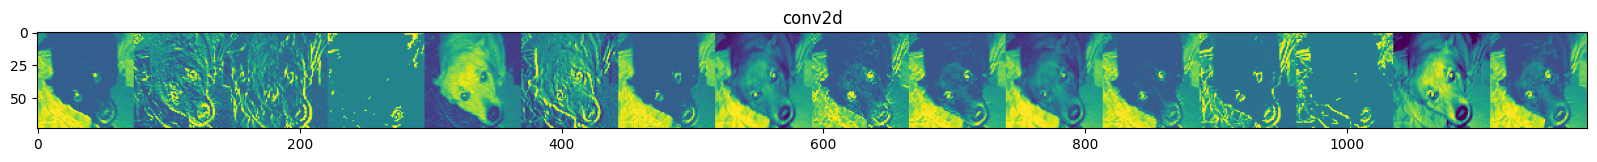

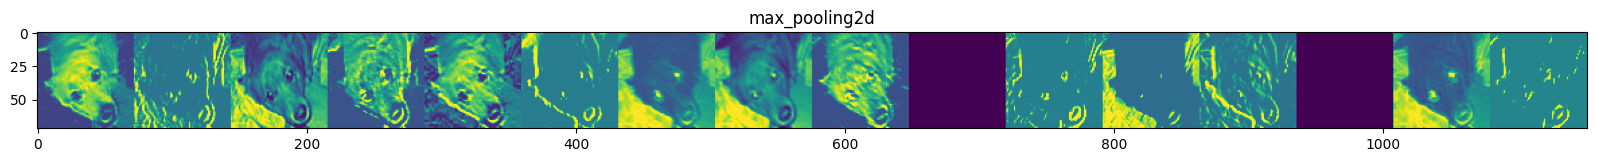

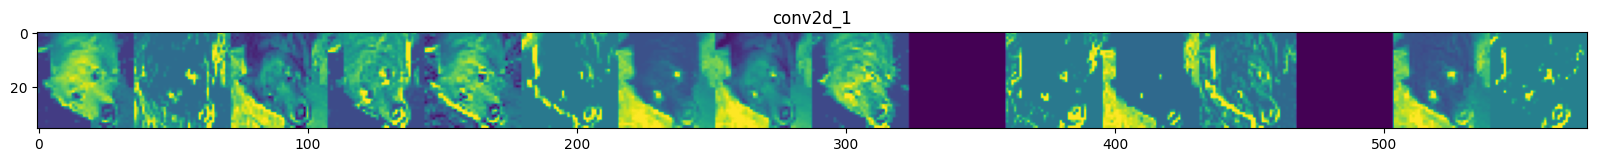

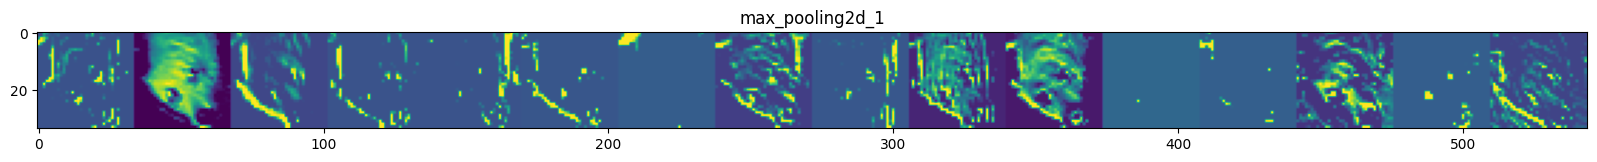

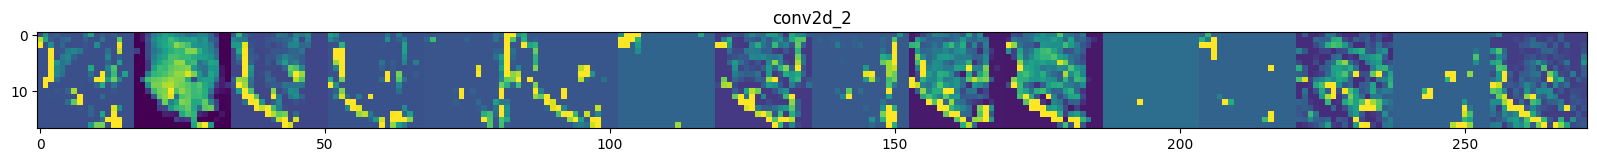

In [23]:
# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:

    # Just do this for the Conv / MaxPool Layers, not the fully-connected layers
    n_features = feature_map.shape[-1] # number of features in the feature map
    size       = feature_map.shape[ 1] # feature map shape (1, size, size, n_features)

    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))

    # Postprocess the feature to be visually palatable
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      # Tile each filter into a horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x

    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

As you can see, we go from the raw pixels of the images to increasingly abstract and compact representations. The respresentations downstream start highlighting what the network pays attention to, and they show fewer and fewer features being "activated"; most are set to 0. This is called **sparsity**--representation sparsity is a key feature of DL! These representations carry *increasingly less* info. about the *original pixels* of the image, but *increasingly refined* info. about the *class* of the image --> you can think of a CNN (or a deep network in gen.) as an info. distillation pipeline.

**3. Evaluate the Model**

Let's plot the training / validation accuracy and loss as collected during training:

<Figure size 640x480 with 0 Axes>

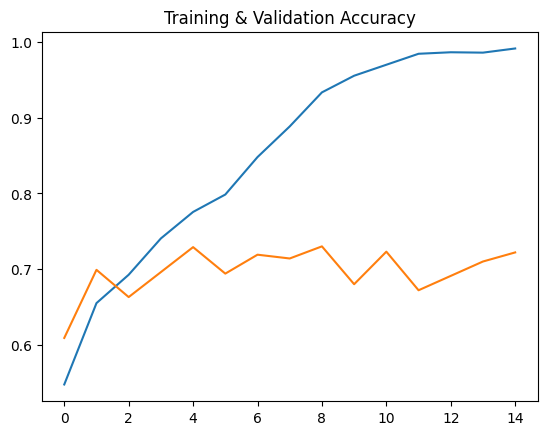

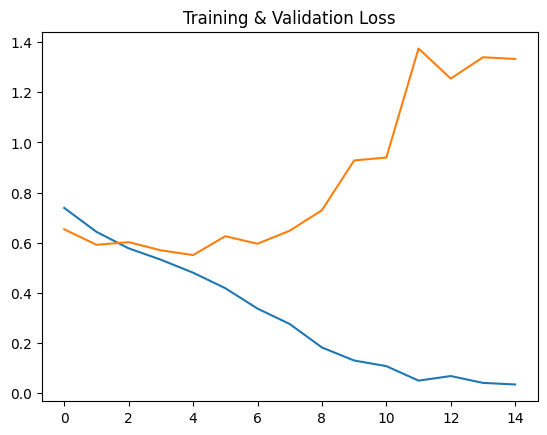

<Figure size 640x480 with 0 Axes>

In [24]:
# Retrieve a list of list results on training and test data sets for each training epoch
acc       = history.history['accuracy']
val_acc   = history.history['val_accuracy']
loss      = history.history['loss']
val_loss  = history.history['val_loss']

# Get number of epochs
epochs    = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training & Validation Accuracy')
plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training & Validation Loss')
plt.figure()

**Overfitting**: Training accuracy (in blue) gets close to 100% (!), while Validation ACCURACY (in green) stalls at 70%. Validation LOSS reaches its minimum after only 5 epochs.

Since we have a relatively small number of training samples (2.000), overfitting should be our no. 1 concern! Overfitting happens when a model exposed to *too few examples* learns *patterns* that do *not generalize well* to new data, i.e., when the model starts using *irrelevant features* for making *predictions*.

Overfitting is the central pb. in ML: given that we are fitting the parameters of our model to a given dataset, how can we make sure that the representations learned by the model will be applicable to data never seen before? How do we avoid learning things that are specific to the training data?

Clean Up

Run the following cell to terminate the kernel and free memory resources:

In [ ]:
# import os, signal

# os.kill(
#     os.getpid(),
#     signal.SIGKILL
# )

## Ex. 1) Classifying Cats & Dogs

In [10]:
import os
import zipfile
import random
import shutil
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile

In [4]:
!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip" \
    -O "/tmp/cats-and-dogs.zip"

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

--2024-01-25 10:22:04--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 69.192.209.23, 2600:1407:e800:1bb::317f, 2600:1407:e800:1ae::317f
Connecting to download.microsoft.com (download.microsoft.com)|69.192.209.23|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.67M   161MB/s    in 7.1s    

2024-01-25 10:22:11 (111 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824887076/824887076]



In [5]:
print(len(os.listdir('/tmp/PetImages/Cat/'))) # Expected output: 12.501
print(len(os.listdir('/tmp/PetImages/Dog/'))) # Expected output: 12.501

12501
12501


In [6]:
try:
  os.mkdir('/tmp/cats-v-dogs')
  os.mkdir('/tmp/cats-v-dogs/training')
  os.mkdir('/tmp/cats-v-dogs/training/cats')
  os.mkdir('/tmp/cats-v-dogs/training/dogs')
  os.mkdir('/tmp/cats-v-dogs/testing')
  os.mkdir('/tmp/cats-v-dogs/testing/cats')
  os.mkdir('/tmp/cats-v-dogs/testing/dogs')
except OSError:
  pass

In [7]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
  files = []
  for filename in os.listdir(SOURCE):
    file = SOURCE + filename
    if os.path.getsize(file) > 0:
      files.append(filename)
    else:
      print(filename + " is zero length, so ignoring.")

  training_length = int(len(files) * SPLIT_SIZE)
  testing_length = int(len(files) - training_length)
  shuffled_set = random.sample(files, len(files))
  training_set = shuffled_set[0:training_length]
  testing_set = shuffled_set[-testing_length:]

  for filename in training_set:
    this_file = SOURCE + filename
    destination = TRAINING + filename
    copyfile(this_file, destination)

  for filename in testing_set:
    this_file = SOURCE + filename
    destination = TESTING + filename
    copyfile(this_file, destination)

In [11]:
CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
TRAINING_CATS_DIR = "/tmp/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "/tmp/cats-v-dogs/testing/cats/"

DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"
TRAINING_DOGS_DIR = "/tmp/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "/tmp/cats-v-dogs/testing/dogs/"

split_size = .9

split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

# Expected output: 666.jpg, 11702.jpg ... is zero length, so ignoring

666.jpg is zero length, so ignoring.
11702.jpg is zero length, so ignoring.


In [12]:
print(len(os.listdir('/tmp/cats-v-dogs/training/cats'))) # Expected output: 11.250
print(len(os.listdir('/tmp/cats-v-dogs/training/dogs'))) # Expected output: 11.250
print(len(os.listdir('/tmp/cats-v-dogs/testing/cats'))) # Expected output: 1.250
print(len(os.listdir('/tmp/cats-v-dogs/testing/cats'))) # Expected output: 1.250

11250
11250
1250
1250


In [13]:
TRAINING_DIR = "/tmp/cats-v-dogs/training/"
train_datagen = ImageDataGenerator(rescale=1/255.)
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=100,
                                                    class_mode='binary',
                                                    target_size=(150, 150))
# Expected output: Found 22.498 images belonging to 2 classes

VALIDATION_DIR = "/tmp/cats-v-dogs/testing/"
validation_datagen = ImageDataGenerator(rescale=1/255.)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=100,
                                                              class_mode='binary',
                                                              target_size=(150, 150))
# Expected output: Found 2.500 images belonging to 2 classes

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [17]:
model_ex_1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_ex_1.compile(loss='binary_crossentropy',
                   optimizer='adam',
                   metrics=['accuracy'])

In [18]:
history_ex_1 = model_ex_1.fit(train_generator,
                              epochs=15,
                              validation_data=validation_generator,
                              verbose=1)

Epoch 1/15
225/225 [==============================] - 63s 226ms/step - loss: 0.6329 - accuracy: 0.6490 - val_loss: 0.5251 - val_accuracy: 0.7424
Epoch 2/15


/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


225/225 [==============================] - 72s 321ms/step - loss: 0.4964 - accuracy: 0.7603 - val_loss: 0.4870 - val_accuracy: 0.7736
Epoch 3/15
225/225 [==============================] - 51s 228ms/step - loss: 0.4260 - accuracy: 0.8032 - val_loss: 0.4336 - val_accuracy: 0.7980
Epoch 4/15
225/225 [==============================] - 51s 225ms/step - loss: 0.3557 - accuracy: 0.8440 - val_loss: 0.3966 - val_accuracy: 0.8240
Epoch 5/15
225/225 [==============================] - 51s 226ms/step - loss: 0.2996 - accuracy: 0.8693 - val_loss: 0.4083 - val_accuracy: 0.8180
Epoch 6/15
225/225 [==============================] - 51s 224ms/step - loss: 0.2331 - accuracy: 0.9015 - val_loss: 0.4254 - val_accuracy: 0.8152
Epoch 7/15
225/225 [==============================] - 51s 225ms/step - loss: 0.1646 - accuracy: 0.9324 - val_loss: 0.5091 - val_accuracy: 0.8196
Epoch 8/15
225/225 [==============================] - 51s 228ms/step - loss: 0.1081 - accuracy: 0.9601 - val_loss: 0.6039 - val_accuracy: 0.8

<Figure size 640x480 with 0 Axes>

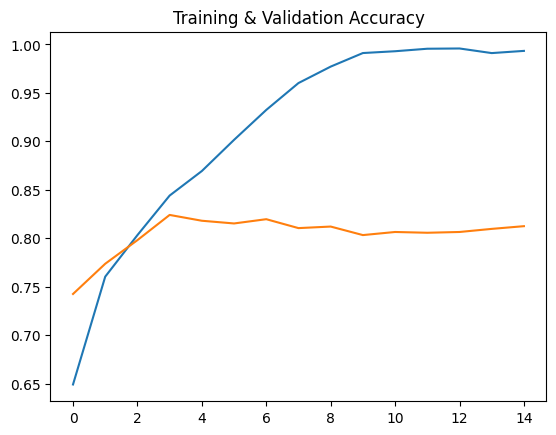

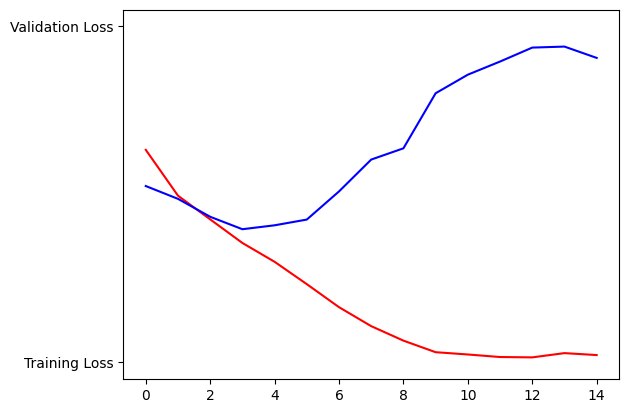

<Figure size 640x480 with 0 Axes>

In [19]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Retrieve a list of list results on training and test data sets for each training epoch
acc       = history_ex_1.history['accuracy']
val_acc   = history_ex_1.history['val_accuracy']
loss      = history_ex_1.history['loss']
val_loss  = history_ex_1.history['val_loss']

# Get number of epochs
epochs    = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training & Validation Accuracy')
plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.figure()

In [20]:
# Codeblock to upload an image and have it classified
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
  # Predicting label
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model_ex_1.predict(images, batch_size=10)
  print(classes[0])
  if classes[0] > 0.5:
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")

Saving horse-8104389_1280.jpg to horse-8104389_1280 (1).jpg
1/1 [==============================] - 0s 271ms/step
[1.]
horse-8104389_1280 (1).jpg is a dog


# § 02.02. Augmentation: A technique to avoid overfitting

## Adding Augmentation to Cats vs. Dogs

Let's start w/ a model that's very effective at learning Cats vs. Dogs. It's similar to above, but w/ updated layers definition: there are now 4 Convolutional Layers w/ 32, 64, 128 and resp. 128 convolutions, and we will train for 100 epochs.

In [22]:
!wget --no-check-certificate \
    "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip" \
    -O /tmp/cats_and_dogs_filtered.zip

--2024-01-25 10:48:39--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.111.207, 142.250.1.207, 108.177.121.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.111.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   176MB/s    in 0.4s    

2024-01-25 10:48:39 (176 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [27]:
import os
import zipfile
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [24]:
local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

validation_dir = os.path.join(base_dir, 'validation')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [25]:
# Rescale images by 1/255.
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

# Flow images in batches of 20
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(150, 150),
                                                    batch_size=20,
                                                    class_mode='binary')
validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                        target_size=(150, 150),
                                                        batch_size=20,
                                                        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [29]:
model_aug = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_aug.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [30]:
history_aug = model_aug.fit(train_generator,
                            epochs=100,
                            steps_per_epoch=100, # 2.000 images = batch_size * steps
                            validation_data=validation_generator,
                            validation_steps=50, # 1.000 images = batch_size * steps
                            verbose=2)

Epoch 1/100
100/100 - 9s - loss: 0.6969 - accuracy: 0.4920 - val_loss: 0.6921 - val_accuracy: 0.5040 - 9s/epoch - 90ms/step
Epoch 2/100
100/100 - 6s - loss: 0.6942 - accuracy: 0.5075 - val_loss: 0.6933 - val_accuracy: 0.5000 - 6s/epoch - 61ms/step
Epoch 3/100
100/100 - 5s - loss: 0.6934 - accuracy: 0.4920 - val_loss: 0.6931 - val_accuracy: 0.5000 - 5s/epoch - 54ms/step
Epoch 4/100
100/100 - 6s - loss: 0.6944 - accuracy: 0.4825 - val_loss: 0.6931 - val_accuracy: 0.5000 - 6s/epoch - 62ms/step
Epoch 5/100
100/100 - 6s - loss: 0.6926 - accuracy: 0.5155 - val_loss: 0.6957 - val_accuracy: 0.5000 - 6s/epoch - 62ms/step
Epoch 6/100
100/100 - 6s - loss: 0.6933 - accuracy: 0.5135 - val_loss: 0.6925 - val_accuracy: 0.5000 - 6s/epoch - 62ms/step
Epoch 7/100
100/100 - 5s - loss: 0.6928 - accuracy: 0.5095 - val_loss: 0.6951 - val_accuracy: 0.5000 - 5s/epoch - 53ms/step
Epoch 8/100
100/100 - 7s - loss: 0.6914 - accuracy: 0.5315 - val_loss: 0.6920 - val_accuracy: 0.5140 - 7s/epoch - 70ms/step
Epoch 9/

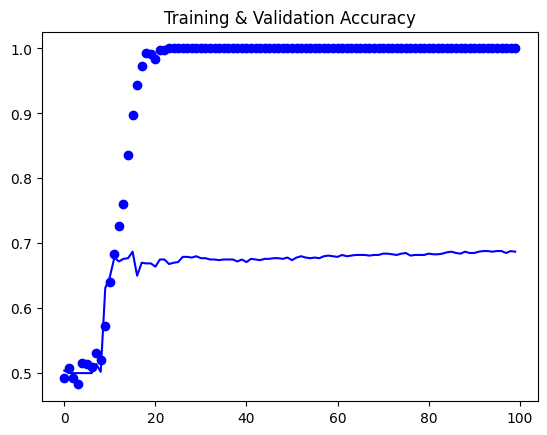

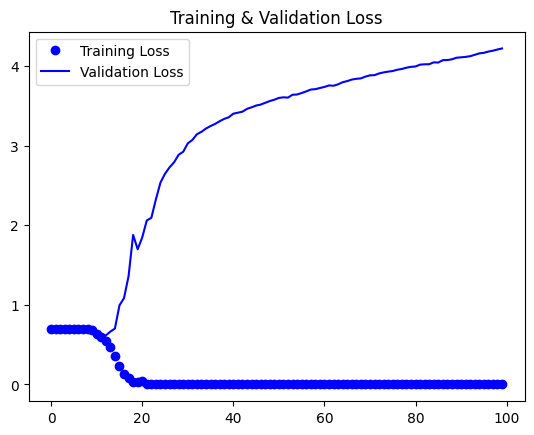

In [31]:
import matplotlib.pyplot as plt

acc       = history_aug.history['accuracy']
val_acc   = history_aug.history['val_accuracy']
loss      = history_aug.history['loss']
val_loss  = history_aug.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label = "Validation Accuracy")
plt.title("Training & Validation Accuracy")

plt.figure()

plt.plot(epochs, loss, 'bo', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label = "Validation Loss")
plt.title("Training & Validation Loss")
plt.legend()

plt.show()

The Training Accuracy is close to 100%, and the Validation Accuracy is in the 70-80% range. This is a great ex. of overfitting--in short, it does very well w/ images it has seen before, but not so well w/ images it hasn't.

Let's see if we can do better to avoid overfitting--one simple method is to augment the images a bit. If you think about it, most pictures of a cat are very similar--the ears are at the top, then the eyes, then the mouth etc. Things like the distance bw. the eyes and ears will always be quite similar too. What if we tweak the images to change this up a bit--rorate the image, squash it etc. There's an API that makes it easy--`ImageDataGenerator`:
* `rotation_range` is a value in degrees (0-180), a range within which to randomly rotate pictures;
* `width_shift` / `height_shift` are ranges (as a fraction of total width / height) within which to randomly translate pictures vertically / horizontally;
* `shear_range` is for randomly applying shearing transformations;
* `zoom_range` is for randomly zooming inside pictures;
* `horizontal_flip` is for randomly flipping half of the images horizontally; this is relevant when there are no assumptions of horizontal asymmetry (e.g., real-world pictures);
* `fill_mode` is the strategy used for filling in newly created pixels, which can appear after a rotation or a width / height shift.

In [32]:
# Rescale images by 1/255. +++ PLUS rotate etc. for image augmentation, for TRAINING only!
train_datagen = ImageDataGenerator(rescale=1/255.,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1/255.)

# Flow images in batches of 20
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(150, 150),
                                                    batch_size=20,
                                                    class_mode='binary')
validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                        target_size=(150, 150),
                                                        batch_size=20,
                                                        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [34]:
model_aug = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_aug.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [35]:
history_aug = model_aug.fit(train_generator,
                            epochs=100,
                            steps_per_epoch=100, # 2.000 images = batch_size * steps
                            validation_data=validation_generator,
                            validation_steps=50, # 1.000 images = batch_size * steps
                            verbose=2)

Epoch 1/100
100/100 - 19s - loss: 0.6981 - accuracy: 0.5360 - val_loss: 0.6842 - val_accuracy: 0.6560 - 19s/epoch - 194ms/step
Epoch 2/100
100/100 - 16s - loss: 0.6887 - accuracy: 0.5240 - val_loss: 0.6878 - val_accuracy: 0.5370 - 16s/epoch - 165ms/step
Epoch 3/100
100/100 - 17s - loss: 0.6860 - accuracy: 0.5305 - val_loss: 0.6881 - val_accuracy: 0.5410 - 17s/epoch - 172ms/step
Epoch 4/100
100/100 - 16s - loss: 0.6890 - accuracy: 0.5085 - val_loss: 0.6930 - val_accuracy: 0.4960 - 16s/epoch - 165ms/step
Epoch 5/100
100/100 - 17s - loss: 0.6893 - accuracy: 0.5270 - val_loss: 0.6913 - val_accuracy: 0.5060 - 17s/epoch - 174ms/step
Epoch 6/100
100/100 - 21s - loss: 0.6756 - accuracy: 0.5845 - val_loss: 0.6853 - val_accuracy: 0.5130 - 21s/epoch - 207ms/step
Epoch 7/100
100/100 - 18s - loss: 0.6779 - accuracy: 0.5585 - val_loss: 0.6435 - val_accuracy: 0.6110 - 18s/epoch - 181ms/step
Epoch 8/100
100/100 - 17s - loss: 0.6686 - accuracy: 0.5860 - val_loss: 0.6552 - val_accuracy: 0.6180 - 17s/epo

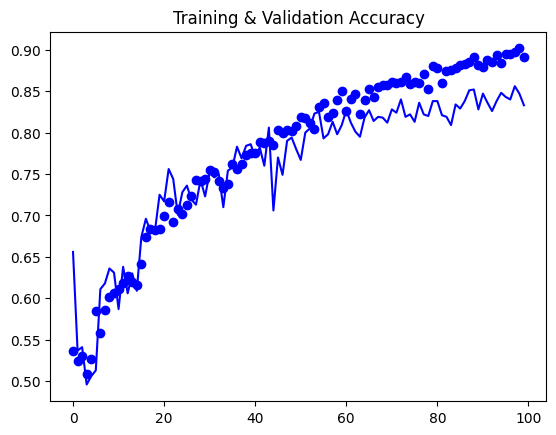

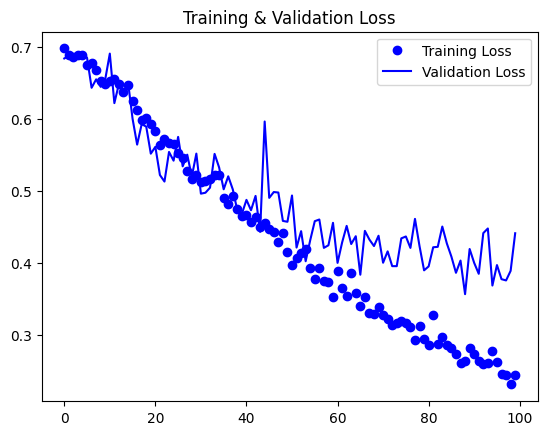

In [36]:
import matplotlib.pyplot as plt

acc       = history_aug.history['accuracy']
val_acc   = history_aug.history['val_accuracy']
loss      = history_aug.history['loss']
val_loss  = history_aug.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label = "Validation Accuracy")
plt.title("Training & Validation Accuracy")

plt.figure()

plt.plot(epochs, loss, 'bo', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label = "Validation Loss")
plt.title("Training & Validation Loss")
plt.legend()

plt.show()

Now, let's add a **Dropout Layer**:

In [38]:
model_aug_drop = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    # +++ PLUS a Dropout Layer
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_aug_drop.compile(loss='binary_crossentropy',
                       optimizer='adam',
                       metrics=['accuracy'])

In [39]:
history_aug_drop = model_aug_drop.fit(train_generator,
                                      epochs=100,
                                      steps_per_epoch=100, # 2.000 images = batch_size * steps
                                      validation_data=validation_generator,
                                      validation_steps=50, # 1.000 images = batch_size * steps
                                      verbose=2)

Epoch 1/100
100/100 - 21s - loss: 0.7081 - accuracy: 0.4930 - val_loss: 0.6916 - val_accuracy: 0.5260 - 21s/epoch - 208ms/step
Epoch 2/100
100/100 - 18s - loss: 0.6931 - accuracy: 0.5070 - val_loss: 0.6913 - val_accuracy: 0.5030 - 18s/epoch - 177ms/step
Epoch 3/100
100/100 - 17s - loss: 0.6926 - accuracy: 0.5020 - val_loss: 0.6909 - val_accuracy: 0.5420 - 17s/epoch - 172ms/step
Epoch 4/100
100/100 - 17s - loss: 0.6910 - accuracy: 0.5365 - val_loss: 0.6912 - val_accuracy: 0.5110 - 17s/epoch - 172ms/step
Epoch 5/100
100/100 - 17s - loss: 0.6882 - accuracy: 0.5430 - val_loss: 0.6865 - val_accuracy: 0.5600 - 17s/epoch - 168ms/step
Epoch 6/100
100/100 - 17s - loss: 0.6897 - accuracy: 0.5325 - val_loss: 0.6963 - val_accuracy: 0.5000 - 17s/epoch - 167ms/step
Epoch 7/100
100/100 - 18s - loss: 0.6920 - accuracy: 0.5065 - val_loss: 0.6897 - val_accuracy: 0.5400 - 18s/epoch - 176ms/step
Epoch 8/100
100/100 - 18s - loss: 0.6912 - accuracy: 0.5405 - val_loss: 0.6869 - val_accuracy: 0.5390 - 18s/epo

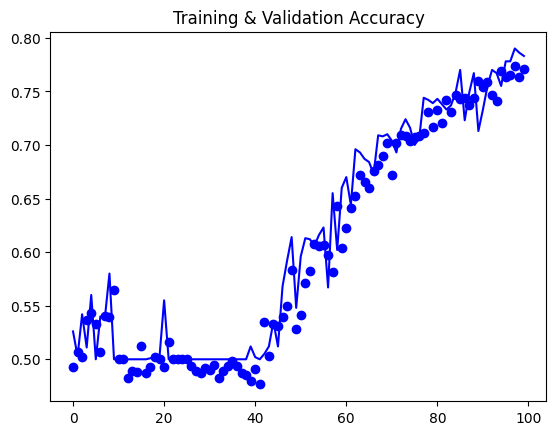

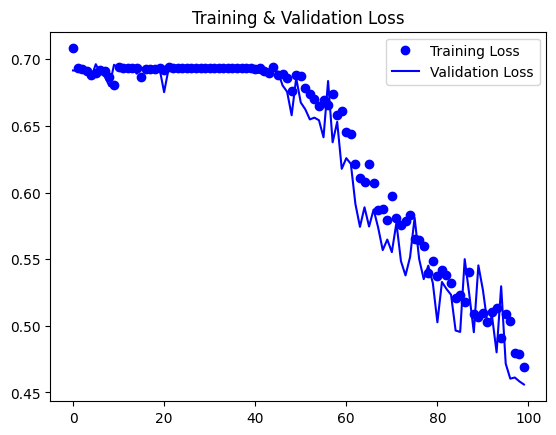

In [40]:
import matplotlib.pyplot as plt

acc       = history_aug_drop.history['accuracy']
val_acc   = history_aug_drop.history['val_accuracy']
loss      = history_aug_drop.history['loss']
val_loss  = history_aug_drop.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label = "Validation Accuracy")
plt.title("Training & Validation Accuracy")

plt.figure()

plt.plot(epochs, loss, 'bo', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label = "Validation Loss")
plt.title("Training & Validation Loss")
plt.legend()

plt.show()

## Exploring Augmentation to Horses vs. Humans

In [41]:
!wget --no-check-certificate \
    "https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip" \
    -O "/tmp/horse-or-human.zip"

!wget --no-check-certificate \
    "https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip" \
    -O "/tmp/validation-horse-or-human.zip"

--2024-01-25 12:02:20--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.196.207, 173.194.197.207, 173.194.74.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.196.207|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2024-01-25 12:02:20 ERROR 404: Not Found.

--2024-01-25 12:02:20--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.196.207, 173.194.197.207, 173.194.74.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.196.207|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2024-01-25 12:02:20 ERROR 404: Not Found.



In [42]:
import os
import zipfile

In [44]:
# Download the training set
!wget "https://storage.googleapis.com/tensorflow-1-public/course2/week3/horse-or-human.zip"

--2024-01-25 12:04:30--  https://storage.googleapis.com/tensorflow-1-public/course2/week3/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.193.207, 173.194.194.207, 173.194.195.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.193.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘horse-or-human.zip’

horse-or-human.zip  100%[===================>] 142.65M   224MB/s    in 0.6s    

2024-01-25 12:04:30 (224 MB/s) - ‘horse-or-human.zip’ saved [149574867/149574867]



In [45]:
# Download the validation set
!wget "https://storage.googleapis.com/tensorflow-1-public/course2/week3/validation-horse-or-human.zip"

--2024-01-25 12:04:38--  https://storage.googleapis.com/tensorflow-1-public/course2/week3/validation-horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.193.207, 173.194.194.207, 173.194.195.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.193.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11480187 (11M) [application/zip]
Saving to: ‘validation-horse-or-human.zip’

validation-horse-or 100%[===================>]  10.95M  --.-KB/s    in 0.08s   

2024-01-25 12:04:38 (135 MB/s) - ‘validation-horse-or-human.zip’ saved [11480187/11480187]



In [47]:
# Extract the archive
zip_ref = zipfile.ZipFile('./horse-or-human.zip', 'r')
zip_ref.extractall('tmp/horse-or-human')

zip_ref = zipfile.ZipFile('./validation-horse-or-human.zip', 'r')
zip_ref.extractall('tmp/validation-horse-or-human')

zip_ref.close()

In [48]:
train_horse_dir = os.path.join('/tmp/horse-or-human/horses')
train_human_dir = os.path.join('/tmp/horse-or-human/humans')

validation_horse_dir = os.path.join('/tmp/validation-horse-or-human/horses')
validation_human_dir = os.path.join('/tmp/validation-horse-or-human/humans')

In [49]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [51]:
train_datagen = ImageDataGenerator(rescale=1/255.,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
validation_datagen = ImageDataGenerator(rescale=1/255.)

train_generator = train_datagen.flow_from_directory('tmp/horse-or-human/',
                                                    target_size=(300, 300),
                                                    batch_size=128,
                                                    class_mode='binary')
validation_generator = validation_datagen.flow_from_directory('tmp/validation-horse-or-human/',
                                                              target_size=(300, 300),
                                                              batch_size=32,
                                                              class_mode='binary')

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [52]:
import tensorflow as tf

In [53]:
model_HvH = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [54]:
model_HvH.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [55]:
history_HvH = model_HvH.fit(train_generator,
                            epochs=100,
                            steps_per_epoch=8,
                            validation_data=validation_generator,
                            validation_steps=8,
                            verbose=1)

Epoch 1/100
8/8 [==============================] - 36s 3s/step - loss: 0.7040 - accuracy: 0.4994 - val_loss: 0.6871 - val_accuracy: 0.7773
Epoch 2/100
8/8 [==============================] - 28s 4s/step - loss: 0.6720 - accuracy: 0.6730 - val_loss: 0.7030 - val_accuracy: 0.5156
Epoch 3/100
8/8 [==============================] - 30s 4s/step - loss: 0.5916 - accuracy: 0.6819 - val_loss: 0.8834 - val_accuracy: 0.5000
Epoch 4/100
8/8 [==============================] - 29s 4s/step - loss: 0.5778 - accuracy: 0.6874 - val_loss: 0.7725 - val_accuracy: 0.5000
Epoch 5/100
8/8 [==============================] - 30s 4s/step - loss: 0.5966 - accuracy: 0.6429 - val_loss: 1.2130 - val_accuracy: 0.5664
Epoch 6/100
8/8 [==============================] - 29s 4s/step - loss: 0.5402 - accuracy: 0.7408 - val_loss: 0.7413 - val_accuracy: 0.6562
Epoch 7/100
8/8 [==============================] - 29s 4s/step - loss: 0.5033 - accuracy: 0.7464 - val_loss: 0.7801 - val_accuracy: 0.7461
Epoch 8/100
8/8 [==========

Exception ignored in: <function _xla_gc_callback at 0x7bd1f59c7010>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 97, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


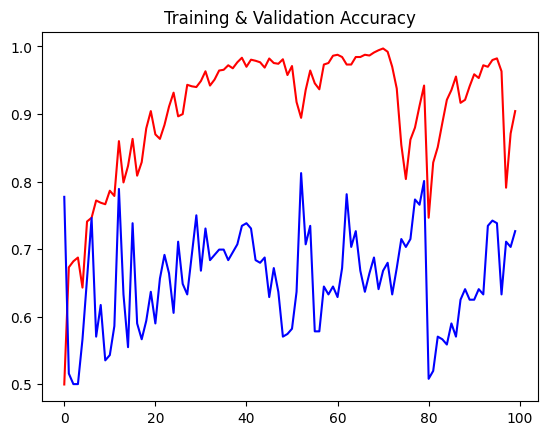

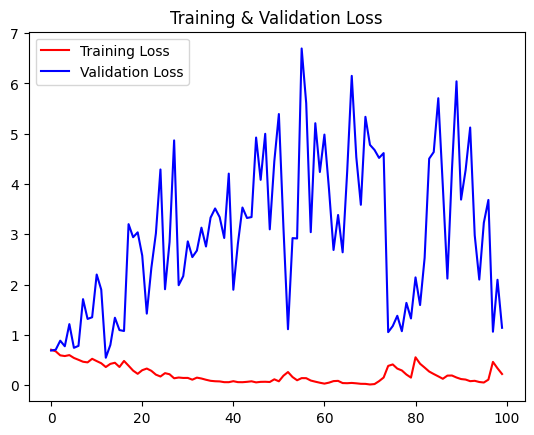

In [56]:
import matplotlib.pyplot as plt

acc       = history_HvH.history['accuracy']
val_acc   = history_HvH.history['val_accuracy']
loss      = history_HvH.history['loss']
val_loss  = history_HvH.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label = "Validation Accuracy")
plt.title("Training & Validation Accuracy")

plt.figure()

plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label = "Validation Loss")
plt.title("Training & Validation Loss")
plt.legend()

plt.show()

## Ex. 2) Improving Cats & Dogs Classifier

In [57]:
TRAINING_DIR = "/tmp/cats-v-dogs/training/"
train_datagen = ImageDataGenerator(rescale=1/255.,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=100,
                                                    class_mode='binary',
                                                    target_size=(150, 150))
# Expected output: Found 22.498 images belonging to 2 classes

VALIDATION_DIR = "/tmp/cats-v-dogs/testing/"
validation_datagen = ImageDataGenerator(rescale=1/255.)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=100,
                                                              class_mode='binary',
                                                              target_size=(150, 150))
# Expected output: Found 2.500 images belonging to 2 classes

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [58]:
model_ex_2 = model_ex_1

model_ex_2.compile(loss='binary_crossentropy',
                   optimizer='adam',
                   metrics=['accuracy'])

In [60]:
history_ex_2 = model_ex_2.fit(train_generator,
                              epochs=15,
                              validation_data=validation_generator,
                              verbose=1)

Epoch 1/15
225/225 [==============================] - ETA: 0s - loss: 0.5269 - accuracy: 0.7428

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


225/225 [==============================] - 196s 874ms/step - loss: 0.5269 - accuracy: 0.7428 - val_loss: 0.5006 - val_accuracy: 0.7596
Epoch 2/15
225/225 [==============================] - 194s 861ms/step - loss: 0.4759 - accuracy: 0.7720 - val_loss: 0.4697 - val_accuracy: 0.7736
Epoch 3/15
225/225 [==============================] - 187s 832ms/step - loss: 0.4553 - accuracy: 0.7846 - val_loss: 0.4633 - val_accuracy: 0.7820
Epoch 4/15
225/225 [==============================] - 185s 823ms/step - loss: 0.4400 - accuracy: 0.7960 - val_loss: 0.4566 - val_accuracy: 0.7724
Epoch 5/15
225/225 [==============================] - 185s 824ms/step - loss: 0.4226 - accuracy: 0.8062 - val_loss: 0.4378 - val_accuracy: 0.7868
Epoch 6/15
225/225 [==============================] - 186s 827ms/step - loss: 0.4078 - accuracy: 0.8128 - val_loss: 0.4106 - val_accuracy: 0.8088
Epoch 7/15
225/225 [==============================] - 186s 826ms/step - loss: 0.4037 - accuracy: 0.8169 - val_loss: 0.4089 - val_accura

<Figure size 640x480 with 0 Axes>

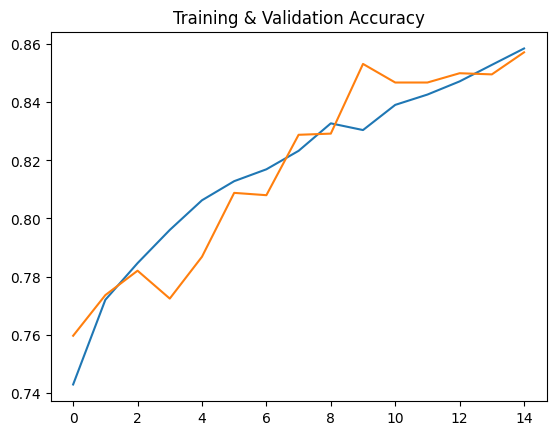

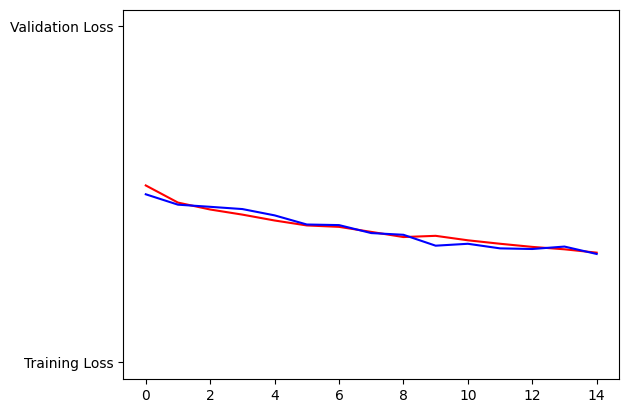

<Figure size 640x480 with 0 Axes>

In [61]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Retrieve a list of list results on training and test data sets for each training epoch
acc       = history_ex_2.history['accuracy']
val_acc   = history_ex_2.history['val_accuracy']
loss      = history_ex_2.history['loss']
val_loss  = history_ex_2.history['val_loss']

# Get number of epochs
epochs    = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training & Validation Accuracy')
plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.figure()

In [62]:
# Codeblock to upload an image and have it classified
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
  # Predicting label
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model_ex_1.predict(images, batch_size=10)
  print(classes[0])
  if classes[0] > 0.5:
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")

Saving wolves-3785362_1280.jpg to wolves-3785362_1280.jpg
1/1 [==============================] - 0s 85ms/step
[1.]
wolves-3785362_1280.jpg is a dog


# § 02.03. Transfer Learning

## Ex. 3) Transfer Learning

In [1]:
# Import all the necessary files!
import os
import zipfile
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# Download the inception v3 weights
!wget --no-check-certificate \
    "https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5" \
    -O "/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"

# Import the inception model
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Create an instance of the inception model from the local pre-trained weights
local_weights_file = "/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"

pre_trained_model = InceptionV3(input_shape = (150, 150, 3),
                                include_top = False,
                                weights = None)
pre_trained_model.load_weights(local_weights_file)

# Make all the layers in the pre-trained model non-trainable
for layer in pre_trained_model.layers:
  layer.trainable = False

# Print the model summary
pre_trained_model.summary() # Expected output--Total params: 21,802,784; Trainable params: 0

--2024-01-25 21:23:42--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.132.207, 74.125.201.207, 74.125.202.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.132.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  88.1MB/s    in 1.0s    

2024-01-25 21:23:43 (88.1 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         [] 

In [3]:
last_desired_layer = pre_trained_model.get_layer("mixed7")
print("Last layer output shape: ", last_desired_layer.output_shape) # Expected output: (None, 7, 7, 768)

last_output = last_desired_layer.output

Last layer output shape:  (None, 7, 7, 768)


In [8]:
# Get the Horse or Human training dataset
!wget -q -P /content/ https://storage.googleapis.com/tensorflow-1-public/course2/week3/horse-or-human.zip

# Get the Horse or Human validation dataset
!wget -q -P /content/ https://storage.googleapis.com/tensorflow-1-public/course2/week3/validation-horse-or-human.zip

In [9]:
test_local_zip = './horse-or-human.zip'
zip_ref = zipfile.ZipFile(test_local_zip, 'r')
zip_ref.extractall('/tmp/training')

val_local_zip = './validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(val_local_zip, 'r')
zip_ref.extractall('/tmp/validation')

zip_ref.close()

In [10]:
# Define example directories
train_dir = '/tmp/training'
validation_dir = '/tmp/validation'

In [11]:
# Build directories
train_horses_dir = os.path.join(train_dir, 'horses')
train_humans_dir = os.path.join(train_dir, 'humans')
validation_horses_dir = os.path.join(validation_dir, 'horses')
validation_humans_dir = os.path.join(validation_dir, 'humans')

train_horses_fnames = os.listdir(train_horses_dir)
train_humans_fnames = os.listdir(train_humans_dir)
validation_horses_fnames = os.listdir(validation_horses_dir)
validation_humans_fnames = os.listdir(validation_humans_dir)

print(len(train_horses_fnames)) # Expected output: 500
print(len(train_humans_fnames)) # Expected output: 527
print(len(validation_horses_fnames)) # Expected output: 128
print(len(validation_humans_fnames)) # Expected output: 128

500
527
128
128


In [13]:
# Add Data Augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1/255.,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
# Note that the validation data should not be augmented!
validation_datagen = ImageDataGenerator(rescale=1/255.)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(150, 150),
                                                    batch_size=32,
                                                    class_mode='binary')
# Expected output: Found 1.027 images belonging to 2 classes.

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = validation_datagen.flow_from_directory(validation_dir,
                                                        target_size=(150, 150),
                                                        batch_size=32,
                                                        class_mode='binary')
# Expected output: Found 256 images belonging to 2 classes.

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [14]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)

# Add a fully connected layer w/ 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)

# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)

# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

model_ex_3 = Model(pre_trained_model.input, x)

model_ex_3.compile(loss='binary_crossentropy',
                   optimizer='adam',
                   metrics=['accuracy'])

model_ex_3.summary() # Expected output--Total params: 47,512,481; Trainable params: 38,537,217

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 74, 74, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 74, 74, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 74, 74, 32)           0         ['batch_normalization[0][0

In [15]:
# Def. a Callback class that stops training once Accuracy reaches 99.9%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.999):
      print("\nReached 99.9% accuracy, so cancelling training!")
      self.model.stop_training = True

In [16]:
# See how many epochs it takes before the callback stops the training at 99.9% accuracy
callbacks = myCallback()

history_ex_3 = model_ex_3.fit(train_generator,
                              epochs=100,
                              # epochs=50,
                              # steps_per_epoch=20, # 1.027 images =~ batch_size * steps
                              validation_data=validation_generator,
                              # validation_steps=10, # 256 images =~ batch_size * steps
                              callbacks=[callbacks],
                              verbose=2)

Epoch 1/100
33/33 - 24s - loss: 0.7363 - accuracy: 0.9143 - val_loss: 0.1396 - val_accuracy: 0.9844 - 24s/epoch - 717ms/step
Epoch 2/100
33/33 - 13s - loss: 0.1099 - accuracy: 0.9844 - val_loss: 0.4045 - val_accuracy: 0.9648 - 13s/epoch - 399ms/step
Epoch 3/100
33/33 - 14s - loss: 0.0658 - accuracy: 0.9951 - val_loss: 0.5848 - val_accuracy: 0.9609 - 14s/epoch - 412ms/step
Epoch 4/100
33/33 - 13s - loss: 0.0183 - accuracy: 0.9971 - val_loss: 0.1329 - val_accuracy: 0.9883 - 13s/epoch - 388ms/step
Epoch 5/100
33/33 - 13s - loss: 0.0937 - accuracy: 0.9883 - val_loss: 0.7559 - val_accuracy: 0.9570 - 13s/epoch - 384ms/step
Epoch 6/100
33/33 - 14s - loss: 0.0676 - accuracy: 0.9903 - val_loss: 0.0606 - val_accuracy: 0.9883 - 14s/epoch - 417ms/step
Epoch 7/100
33/33 - 13s - loss: 0.0507 - accuracy: 0.9942 - val_loss: 0.1141 - val_accuracy: 0.9844 - 13s/epoch - 388ms/step
Epoch 8/100
33/33 - 13s - loss: 0.0244 - accuracy: 0.9961 - val_loss: 0.0221 - val_accuracy: 0.9922 - 13s/epoch - 390ms/step


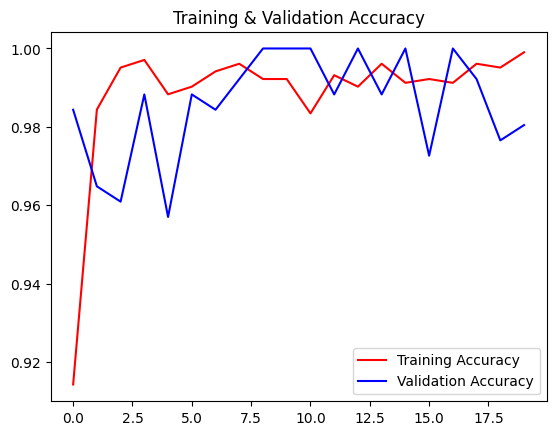

<Figure size 640x480 with 0 Axes>

In [17]:
acc       = history_ex_3.history['accuracy']
val_acc   = history_ex_3.history['val_accuracy']
loss      = history_ex_3.history['loss']
val_loss  = history_ex_3.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label = "Validation Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend(loc=0)
plt.figure()

plt.show()

# § 02.04. Multiclass Classifications

## Rock-Paper-Scissors Classifier

In [112]:
!wget --no-check-certificate \
    "https://storage.googleapis.com/tensorflow-1-public/course2/week4/rps.zip"

!wget --no-check-certificate \
    "https://storage.googleapis.com/tensorflow-1-public/course2/week4/rps-test-set.zip"

--2024-01-25 14:31:17--  https://storage.googleapis.com/tensorflow-1-public/course2/week4/rps.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.234.207, 142.251.171.207, 142.251.172.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.234.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 200682221 (191M) [application/zip]
Saving to: ‘rps.zip’

rps.zip             100%[===================>] 191.38M   120MB/s    in 1.6s    

2024-01-25 14:31:19 (120 MB/s) - ‘rps.zip’ saved [200682221/200682221]

--2024-01-25 14:31:19--  https://storage.googleapis.com/tensorflow-1-public/course2/week4/rps-test-set.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.234.207, 142.251.171.207, 142.251.172.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.234.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29516758 (28M) [application/zip]
Saving to: ‘rps-test

In [113]:
import os
import zipfile

In [114]:
local_zip = './rps.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('tmp/rps-train')
zip_ref.close()

local_zip = './rps-test-set.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('tmp/rps-test')
zip_ref.close()

In [117]:
base_dir = 'tmp/rps-train/rps'

rock_dir = os.path.join(base_dir, 'rock')
paper_dir = os.path.join(base_dir, 'paper')
scissors_dir = os.path.join(base_dir, 'scissors')

# rock_dir = os.path.join('/tmp/rps/rock')
# paper_dir = os.path.join('/tmp/rps/paper')
# scissors_dir = os.path.join('/tmp/rps/scissors')

print('total training rock images:', len(os.listdir(rock_dir)))
print('total training paper images:', len(os.listdir(paper_dir)))
print('total training scissors images:', len(os.listdir(scissors_dir)))

rock_files = os.listdir(rock_dir)
print(rock_files[:10])

paper_files = os.listdir(paper_dir)
print(paper_files[:10])

scissors_files = os.listdir(scissors_dir)
print(scissors_files[:10])

total training rock images: 840
total training paper images: 840
total training scissors images: 840
['rock06ck02-074.png', 'rock02-012.png', 'rock01-097.png', 'rock03-105.png', 'rock05ck01-058.png', 'rock02-038.png', 'rock05ck01-065.png', 'rock05ck01-047.png', 'rock01-026.png', 'rock02-044.png']
['paper07-001.png', 'paper03-046.png', 'paper05-110.png', 'paper07-056.png', 'paper03-087.png', 'paper03-015.png', 'paper03-019.png', 'paper07-115.png', 'paper01-000.png', 'paper01-058.png']
['scissors01-052.png', 'testscissors02-089.png', 'testscissors01-069.png', 'testscissors03-011.png', 'scissors01-023.png', 'scissors04-070.png', 'testscissors02-104.png', 'scissors02-019.png', 'testscissors03-103.png', 'testscissors02-034.png']


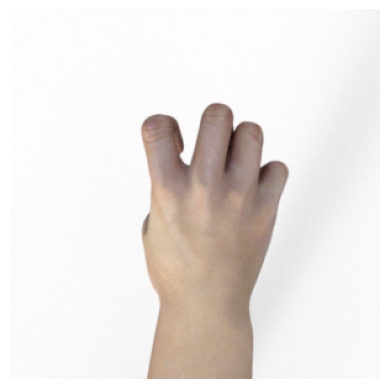

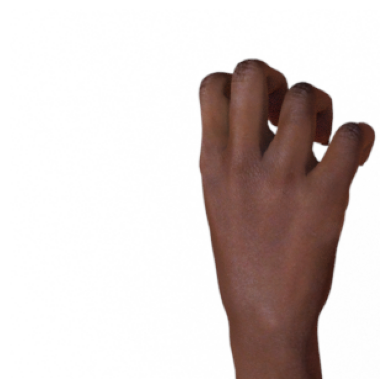

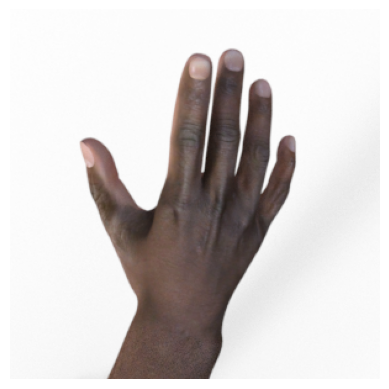

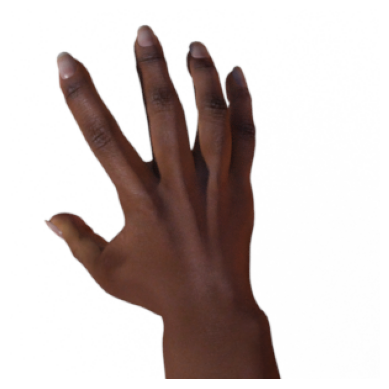

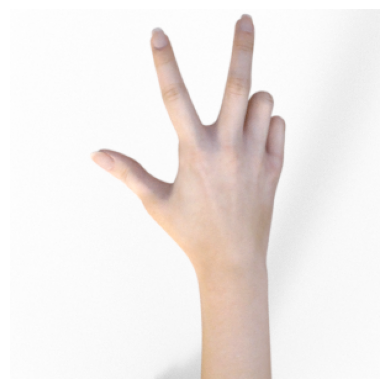

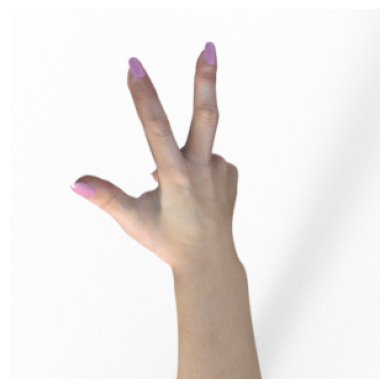

In [118]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

pic_index = 2

next_rock = [os.path.join(rock_dir, fname)
                for fname in rock_files[pic_index - 2 : pic_index]]
next_paper = [os.path.join(paper_dir, fname)
                for fname in paper_files[pic_index - 2 : pic_index]]
next_scissors = [os.path.join(scissors_dir, fname)
                for fname in scissors_files[pic_index - 2 : pic_index]]

for i, img_path in enumerate(next_rock + next_paper + next_scissors):
  # print(img_path)
  img = mpimg.imread(img_path)
  plt.imshow(img)
  plt.axis('Off')
  plt.show()

In [121]:
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [123]:
TRAINING_DIR = "tmp/rps-train/rps"
training_datagen = ImageDataGenerator(rescale=1/255.,
                                      rotation_range=40,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      shear_range=0.2,
                                      zoom_range=0.2,
                                      horizontal_flip=True,
                                      fill_mode='nearest')
VALIDATION_DIR = "tmp/rps-test/rps-test-set"
validation_datagen = ImageDataGenerator(rescale=1/255.)

train_generator = training_datagen.flow_from_directory(TRAINING_DIR,
                                                       target_size=(150, 150),
                                                       batch_size=126,
                                                       class_mode='categorical')
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              target_size=(150, 150),
                                                              batch_size=126,
                                                              class_mode='categorical')

Found 2520 images belonging to 3 classes.
Found 372 images belonging to 3 classes.


In [125]:
model_rps = tf.keras.models.Sequential([
    # The 1st convolution & Input layer (note image input_shape of size 150x150 w/ 3 bytes of color)
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The 2nd convolution
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The 3rd convolution
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The 4th convolution
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    # Flatten the results to feed into a DNN, & dropout
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    # Hidden layer of 512 neurons
    tf.keras.layers.Dense(512, activation='relu'),
    # Output layer (for 3 classes)
    tf.keras.layers.Dense(3, activation='softmax')
])

In [126]:
model_rps.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_136 (Conv2D)         (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d_46 (MaxPooli  (None, 74, 74, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_137 (Conv2D)         (None, 72, 72, 64)        36928     
                                                                 
 max_pooling2d_47 (MaxPooli  (None, 36, 36, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_138 (Conv2D)         (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_48 (MaxPooli  (None, 17, 17, 128)      

In [127]:
model_rps.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [128]:
history_rps = model_rps.fit(train_generator,
                            epochs=25,
                            steps_per_epoch=20,
                            validation_data=validation_generator,
                            validation_steps=3,
                            verbose=1)

Epoch 1/25
20/20 [==============================] - 33s 1s/step - loss: 1.0952 - accuracy: 0.3730 - val_loss: 0.9944 - val_accuracy: 0.5753
Epoch 2/25
20/20 [==============================] - 25s 1s/step - loss: 0.9678 - accuracy: 0.5127 - val_loss: 0.6397 - val_accuracy: 0.7715
Epoch 3/25
20/20 [==============================] - 26s 1s/step - loss: 0.7618 - accuracy: 0.6492 - val_loss: 0.3725 - val_accuracy: 0.9301
Epoch 4/25
20/20 [==============================] - 28s 1s/step - loss: 0.5994 - accuracy: 0.7369 - val_loss: 0.2767 - val_accuracy: 0.9516
Epoch 5/25
20/20 [==============================] - 26s 1s/step - loss: 0.4604 - accuracy: 0.8179 - val_loss: 0.2074 - val_accuracy: 0.9435
Epoch 6/25
20/20 [==============================] - 25s 1s/step - loss: 0.4319 - accuracy: 0.8214 - val_loss: 0.2382 - val_accuracy: 0.8790
Epoch 7/25
20/20 [==============================] - 26s 1s/step - loss: 0.3251 - accuracy: 0.8734 - val_loss: 0.2210 - val_accuracy: 0.8817
Epoch 8/25
20/20 [==

In [129]:
model_rps.save("rps.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [130]:
import matplotlib.pyplot as plt

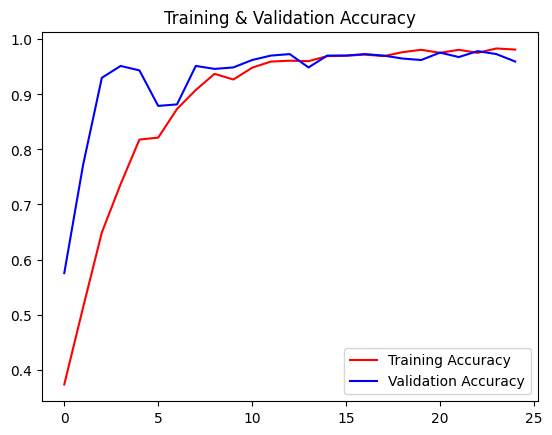

<Figure size 640x480 with 0 Axes>

In [131]:
acc       = history_rps.history['accuracy']
val_acc   = history_rps.history['val_accuracy']
loss      = history_rps.history['loss']
val_loss  = history_rps.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label = "Validation Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend(loc=0)
plt.figure()

plt.show()

In [132]:
import numpy as np

from google.colab import files
from keras.preprocessing import image

In [136]:
uploaded = files.upload()

for fn in uploaded.keys():
  # Predicting label
  path = fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model_rps.predict(images, batch_size=10)
  print(fn)
  print(classes)

Saving scissors4.png to scissors4.png
1/1 [==============================] - 0s 22ms/step
scissors4.png
[[0. 0. 1.]]


## Ex. 4) Classifying Images of Sign Languages

See Final Assignment notebook: C2W4_Assignment.ipynb